In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
import shutil
import random
from skimage.io import imread
from PIL import Image

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_addons as tfa
import kerastuner as kt
  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam, RMSprop, SGD
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from kerastuner.tuners import RandomSearch

# scikit-learn
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [5]:
train_dir = Path('images_split/Training')
val_dir = Path('images_split/Validation')
test_dir = Path('images_split/Test')

### Image Generators

In [6]:
img_width, img_height = 256, 256
batch_size = 64

train_generator = image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical')

val_generator = image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

test_generator = image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

Found 11596 files belonging to 114 classes.
Found 2485 files belonging to 114 classes.
Found 2486 files belonging to 114 classes.


# Model

In [7]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

In [28]:
def create_model(input_shape, n_classes, optimizer='adam', metrics=['accuracy']):
    """
    Compiles a model integrated with ResNet50V2 pretrained layers and data augmentation
        input_shape: tuple - the shape of input images (width, height, channels)
        n_classes: int - number of classes for the output layer
        optimizer: string (defaults to 'adam')
        optimizer: list (defaults to 'accuracy')
    """
    # Data augmentation layers
    data_augmentation = Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.3),
        RandomTranslation(0.1, 0.2),
        RandomRotation(0.2)
    ])

    # Input + data augmentation
    input_img = Input(shape=input_shape)
    augmented_img = data_augmentation(input_img)

    # Load the ResNet50V2 model with pre-trained weights, excluding the top (fully connected) layers
    resnet50v2_base = ResNet50V2(include_top=False, weights='imagenet', input_tensor=augmented_img)
    resnet50v2_base.trainable = False

    # Adding last layers
    pooled_output = GlobalAveragePooling2D()(resnet50v2_base.output)
    dense_layer = Dense(256, activation='relu')(pooled_output)
    dropout_layer = Dropout(0.25)(dense_layer)
    dense_layer = Dense(256, activation='relu')(dropout_layer)
    dropout_layer = Dropout(0.25)(dense_layer)
    output_layer = Dense(n_classes, activation='softmax')(dropout_layer)

    # Final model
    model = Model(inputs=input_img, outputs=output_layer)

    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

    return model


In [45]:
opt_adam = Adam(learning_rate=0.001)
f1 = F1Score(num_classes=114, average='weighted')

model = create_model(input_shape=(256, 256, 3),
                     n_classes=114,
                     optimizer=opt_adam,
                     metrics=['accuracy', f1])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['sequential_1[0][0]']        
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                              

In [29]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='resnet50v2_model_best.weights.hdf5',
                             save_best_only=True,
                             verbose=1,
                             monitor='val_loss',
                             mode='min')


early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [48]:
# Train
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    callbacks=[checkpoint, early_stop])

Epoch 1/200
182/182 [==============================] - ETA: 0s - loss: 4.3242 - accuracy: 0.0738 - f1_score: 0.0482
Epoch 1: val_loss improved from inf to 3.88808, saving model to resnet50v2_model_best.weights.hdf5
182/182 [==============================] - 67s 293ms/step - loss: 4.3242 - accuracy: 0.0738 - f1_score: 0.0482 - val_loss: 3.8881 - val_accuracy: 0.1280 - val_f1_score: 0.0763
Epoch 2/200
181/182 [============================>.] - ETA: 0s - loss: 3.8964 - accuracy: 0.1228 - f1_score: 0.0942
Epoch 2: val_loss improved from 3.88808 to 3.61327, saving model to resnet50v2_model_best.weights.hdf5
182/182 [==============================] - 48s 262ms/step - loss: 3.8960 - accuracy: 0.1228 - f1_score: 0.0942 - val_loss: 3.6133 - val_accuracy: 0.1694 - val_f1_score: 0.1246
Epoch 3/200
182/182 [==============================] - ETA: 0s - loss: 3.6686 - accuracy: 0.1521 - f1_score: 0.1250
Epoch 3: val_loss improved from 3.61327 to 3.49769, saving model to resnet50v2_model_best.weights.

In [49]:
# Evaluate
model.load_weights('resnet50v2_model_best.weights.hdf5')
loss, accuracy, f1 = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)

39/39 [==============================] - 11s 294ms/step - loss: 2.9766 - accuracy: 0.3182 - f1_score: 0.3028
Test Loss: 2.97662091255188
Test Accuracy: 0.3181818127632141
Test F1 Score: 0.302795946598053


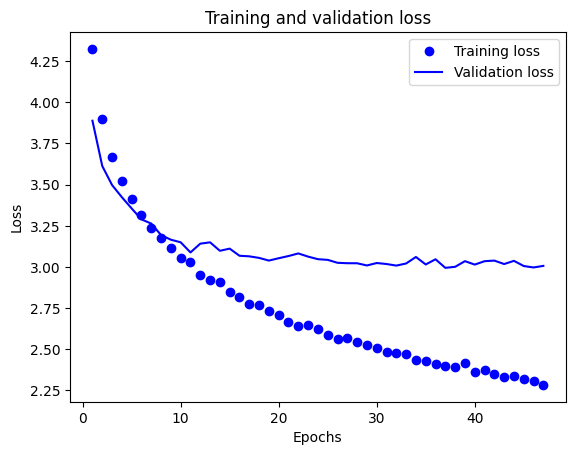

In [50]:
# Loss visualization
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Keras Tuning

In [88]:
def create_model_hypertune(input_shape, n_classes, optimizer='adam', metrics=['accuracy']):
    # Data augmentation layers
    data_augmentation = Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.3),
        RandomTranslation(0.1, 0.2),
        RandomRotation(0.2)
    ])

    # Input + data augmentation
    input_img = Input(shape=input_shape)
    augmented_img = data_augmentation(input_img)

    # Load the ResNet50V2 model with pre-trained weights, excluding the top (fully connected) layers
    resnet50v2_base = ResNet50V2(include_top=False, weights='imagenet', input_tensor=augmented_img)
    resnet50v2_base.trainable = False

    # Adding last layers
    pooled_output = GlobalAveragePooling2D()(resnet50v2_base.output)
    dense_layer = Dense(256, activation='relu')(pooled_output)
    dropout_layer = Dropout(0.25)(dense_layer)
    dense_layer = Dense(256, activation='relu')(dropout_layer)
    dropout_layer = Dropout(0.25)(dense_layer)
    output_layer = Dense(n_classes, activation='softmax')(dropout_layer)

    # Final model
    model = Model(inputs=input_img, outputs=output_layer)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

    return model

In [89]:
def model_builder(hp):
    input_shape = (256, 256, 3)
    n_classes = 114
    f1 = F1Score(num_classes=n_classes, average='weighted')

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if optimizer_name == 'adam':
        optimizer = Adam(hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
    else:
        optimizer = SGD(hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))

    model = create_model_hypertune(input_shape, n_classes, optimizer=optimizer, metrics=['accuracy', f1])

    return model

In [90]:
checkpoint = ModelCheckpoint(filepath='resnet50v2_model_best.weights.hdf5',
                             save_best_only=True,
                             verbose=1,
                             monitor='val_loss',
                             mode='min')


early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [93]:
tuner = RandomSearch(
    model_builder,
    objective=kt.Objective("val_f1_score", direction="max"),
    max_trials=10, 
    directory='tuner_results',
    project_name='hypertune_resnet50v2'
)

# Perform the hyperparameter search
tuner.search(train_generator, validation_data=val_generator, epochs=200, callbacks=[early_stop, checkpoint])

Trial 10 Complete [10h 30m 15s]
val_f1_score: 0.22944335639476776

Best val_f1_score So Far: 0.3285159468650818
Total elapsed time: 1d 16h 55m 43s


In [94]:
best_model = tuner.get_best_models(num_models=1)[0]

In [96]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model_hyper = tuner.hypermodel.build(best_hps)

In [103]:
print(f"Best number of learning_rate: {best_hps.get('learning_rate')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")

Best number of learning_rate: 0.015330327320497971
Best dropout optimizer: adamgrad


In [104]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for param_name, param_value in best_hps.get_config().items():
    print(f"Hyperparameter: {param_name}, Value: {param_value}")

Hyperparameter: space, Value: [{'class_name': 'Choice', 'config': {'name': 'optimizer', 'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'adamgrad'], 'ordered': False}}, {'class_name': 'Float', 'config': {'name': 'learning_rate', 'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}}]
Hyperparameter: values, Value: {'optimizer': 'adamgrad', 'learning_rate': 0.015330327320497971}


**NOTE:**
The output is displaying "adamgrad," but in actuality we believe the optimizer used is "sgd". This happened because during the initial execution of the code, an error occurred related to "adamgrad" due to the absence of this optimizer in the earlier version of Keras (we're using an old version to be able CUDA/GPU). So, when we switched to using "sgd" instead, despite this change, the optimizer labels saved during the initial run, including "adamgrad".

In [97]:
best_model.save('best_model.h5')

# Error Analysis - Confusion Matrix

39/39 [==============================] - 6s 165ms/step


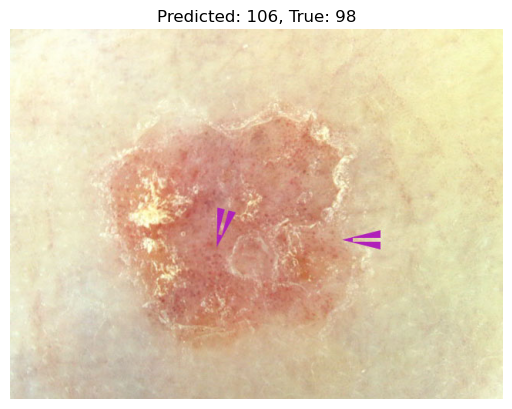

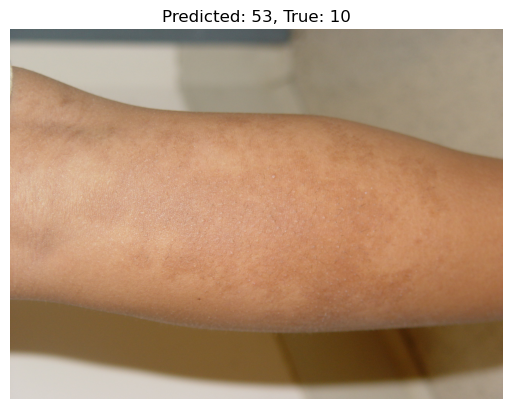

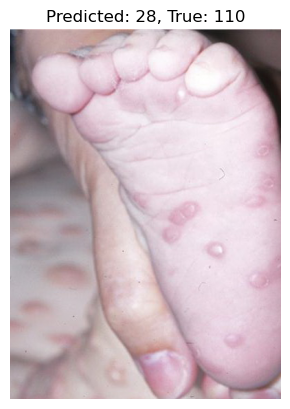

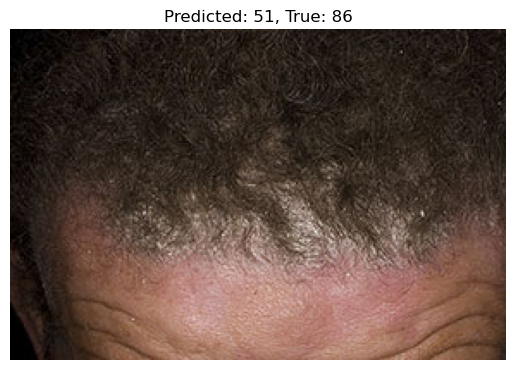

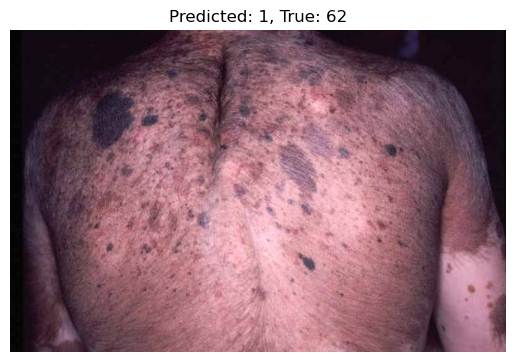

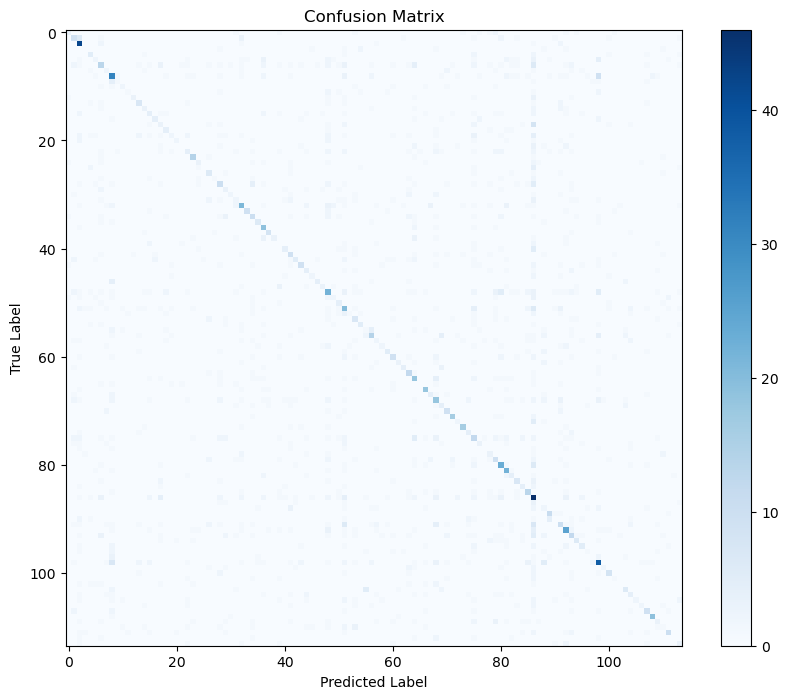

In [100]:
# Generate predictions
predictions = best_model.predict(val_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels
true_labels = []
for images, labels in val_generator:
    true_labels.extend(np.argmax(labels, axis=1))  # Extract true labels from one-hot encoded format

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize misclassified images
misclassified_indices = np.where(predicted_labels != true_labels)[0]
num_images_to_visualize = 5
selected_indices = np.random.choice(misclassified_indices, num_images_to_visualize, replace=False)

for index in selected_indices:
    image = val_generator.file_paths[index]  
    predicted_label = predicted_labels[index]
    true_label = true_labels[index]
    
    plt.imshow(plt.imread(image))
    plt.title(f'Predicted: {predicted_label}, True: {true_label}')
    plt.axis('off')
    plt.show()

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

39/39 [==============================] - 7s 171ms/step


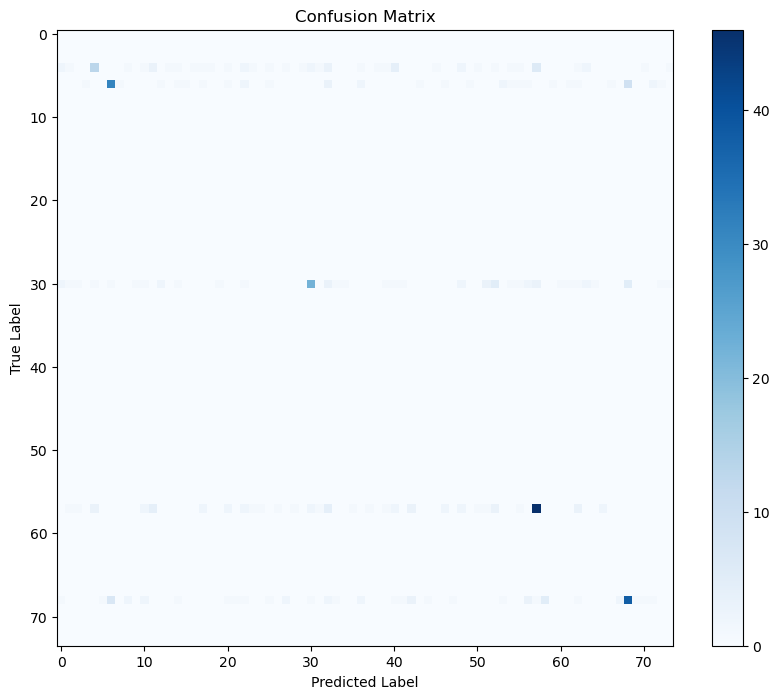

In [101]:
# Generate predictions
predictions = best_model.predict(val_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels and counts of each class
true_labels = []
class_counts = {}
for images, labels in val_generator:
    true_labels.extend(np.argmax(labels, axis=1))  # Extract true labels from one-hot encoded format
    for label in np.argmax(labels, axis=1):
        class_counts[label] = class_counts.get(label, 0) + 1

# Select top 5 classes with the most available data
top_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:5]

# Filter the predictions and true labels for the selected classes
filtered_predicted_labels = []
filtered_true_labels = []
for pred_label, true_label in zip(predicted_labels, true_labels):
    if true_label in top_classes:
        filtered_predicted_labels.append(pred_label)
        filtered_true_labels.append(true_label)

# Calculate confusion matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [40]:
from keras.models import load_model
loaded_model = load_model('best_model.h5')

39/39 [==============================] - 6s 160ms/step
Most predicted label: 86


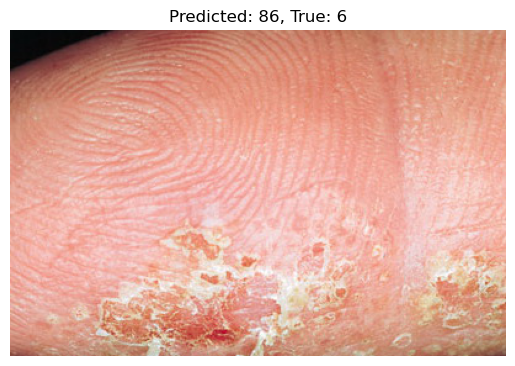

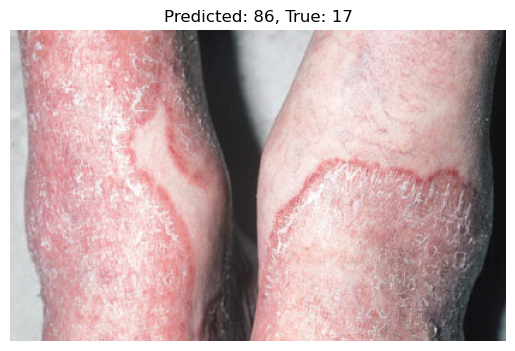

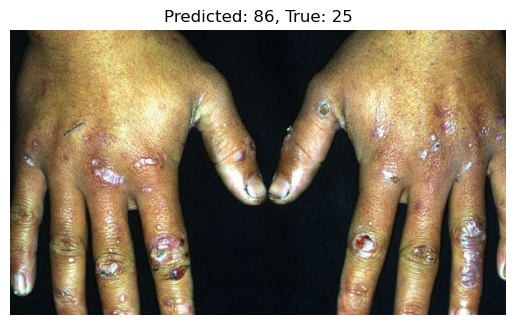

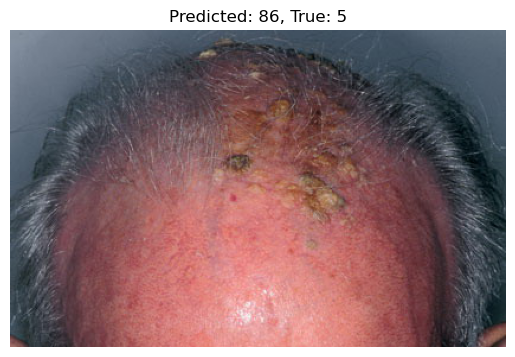

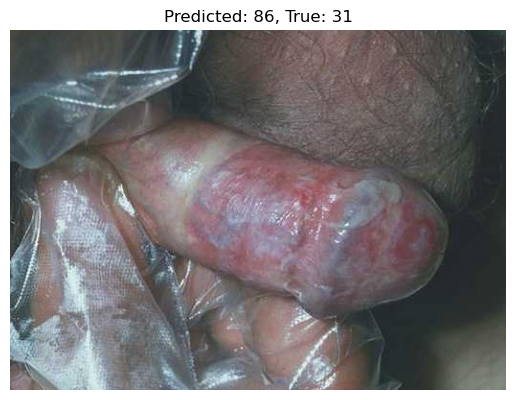

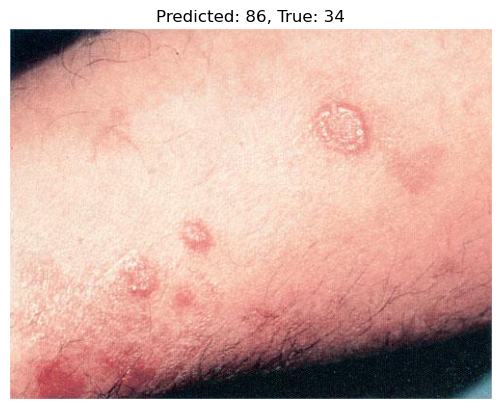

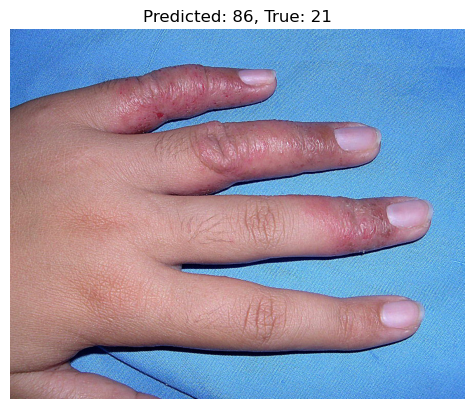

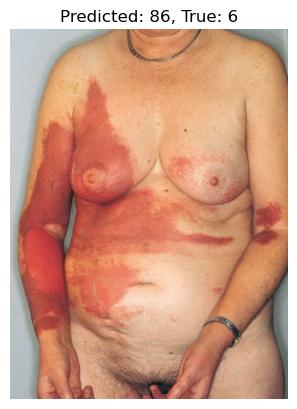

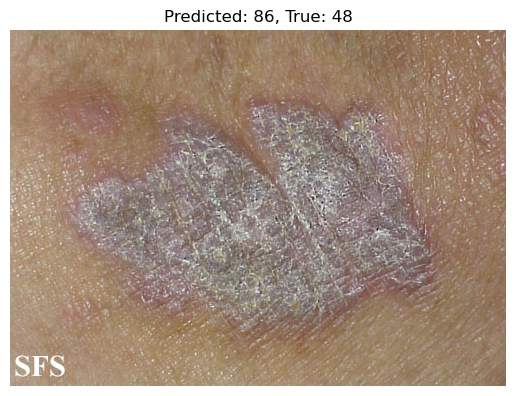

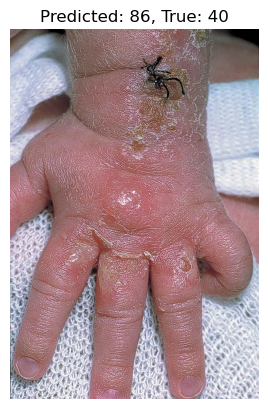

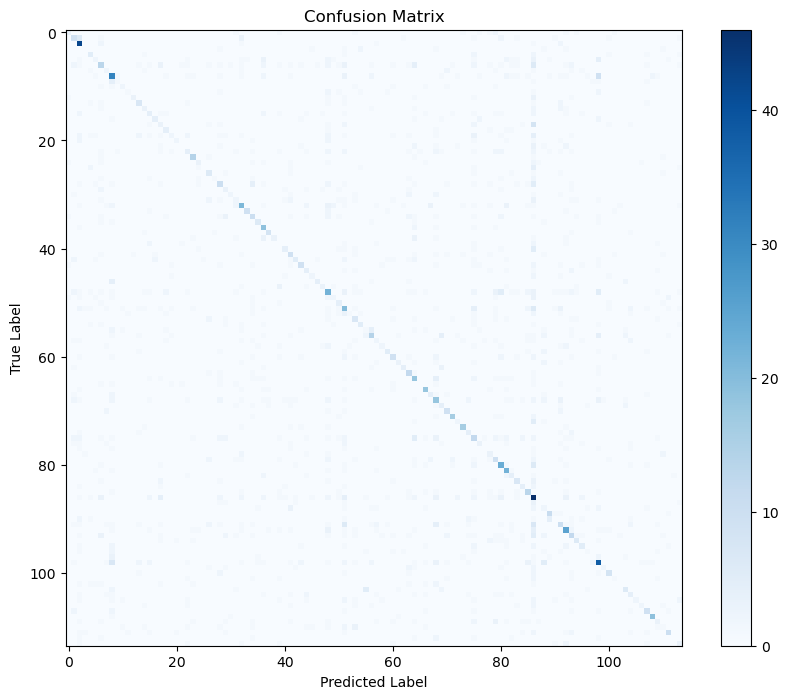

In [43]:
# Generate predictions
predictions = loaded_model.predict(val_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels
true_labels = []
for images, labels in val_generator:
    true_labels.extend(np.argmax(labels, axis=1))

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Find the most predicted label
most_predicted_label = np.argmax(np.sum(cm, axis=0))
print(f"Most predicted label: {most_predicted_label}")

# Find indices of misclassified images for the most predicted label
misclassified_indices = np.where((predicted_labels == most_predicted_label) & (predicted_labels != true_labels))[0]

# Visualize some misclassified images for the most predicted label
num_images_to_visualize = 10
selected_indices = np.random.choice(misclassified_indices, num_images_to_visualize, replace=False)
for index in selected_indices:
    image = val_generator.file_paths[index]
    predicted_label = predicted_labels[index]
    true_label = true_labels[index]
    plt.imshow(plt.imread(image))
    plt.title(f'Predicted: {predicted_label}, True: {true_label}')
    plt.axis('off')
    plt.show()

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()